<a href="https://colab.research.google.com/github/ZenoVka-Vestraq/Pet-Recognition-Classifier/blob/main/Train_a_Pets_Recognition_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a Pet Recognition Classifier


## Load and prepare Data

First we need to update the notebook to the latest version of fastai.

In [1]:
!pip install -Uqq fastai 
from fastai.vision.all import *

     |████████████████████████████████| 213 kB 18.1 MB/s 
     |████████████████████████████████| 61 kB 5.1 MB/s 


At first we are downloading the Pets Dataset, containing about 14.7k images of various types of pets.
Documentation for all Datasets: https://docs.fast.ai/data.external

In [2]:
#Search for Dataset using URL function
URLs.PETS

'https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet.tgz'

In [ ]:
#Download Dataset with untar
Path = untar_data(URLs.PETS); Path

Path('/root/.fastai/data/oxford-iiit-pet')

In [ ]:
#How many images are we dealing with
len(get_image_files(Path))

14780

In [ ]:
#Find out where the Data is located
get_image_files(Path)

(#14780) [Path('/root/.fastai/data/oxford-iiit-pet/annotations/trimaps/yorkshire_terrier_129.png'),Path('/root/.fastai/data/oxford-iiit-pet/annotations/trimaps/great_pyrenees_142.png'),Path('/root/.fastai/data/oxford-iiit-pet/annotations/trimaps/chihuahua_132.png'),Path('/root/.fastai/data/oxford-iiit-pet/annotations/trimaps/leonberger_149.png'),Path('/root/.fastai/data/oxford-iiit-pet/annotations/trimaps/shiba_inu_146.png'),Path('/root/.fastai/data/oxford-iiit-pet/annotations/trimaps/British_Shorthair_195.png'),Path('/root/.fastai/data/oxford-iiit-pet/annotations/trimaps/Persian_269.png'),Path('/root/.fastai/data/oxford-iiit-pet/annotations/trimaps/american_pit_bull_terrier_50.png'),Path('/root/.fastai/data/oxford-iiit-pet/annotations/trimaps/Birman_41.png'),Path('/root/.fastai/data/oxford-iiit-pet/annotations/trimaps/Sphynx_229.png')...]

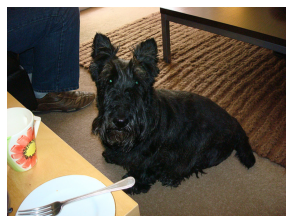

In [ ]:
#Conduct image sampling checks
img = PILImage.create('/root/.fastai/data/oxford-iiit-pet/images/scottish_terrier_11.jpg')
img.show()

In [ ]:
#Deciding which three pets types we want to classify
labelA = 'pug'
labelB = 'Abyssinian'
labelC = 'Birman'

**Some Data Preperation**

Preperation to make the data handling easier. 

1.   Removing all images that don't have labelA, labelB or labelC
2.   Renaming images with labelA, labelB or labelC to have that label in their filename



In [ ]:
#Loop through all Images downloaded
for img in get_image_files(Path):    
  #Rename Images so that the Label (pug, Abyssinian or Birman) is in the file name
  if labelA in str(img):
    img.rename(f"{img.parent}/{labelA}_{img.name}")
  elif labelB in str(img):
    img.rename(f"{img.parent}/{labelB}_{img.name}")
  elif labelC in str(img):
    img.rename(f"{img.parent}/{labelC}_{img.name}")
  else: os.remove(img) #If the Images are not part of labelA or labelB

len(get_image_files(Path))

1200

## Train Model

In [ ]:
def GetLabel(fileName):
  return fileName.split('_')[0]

GetLabel("pug_75.jpg") #Testing

'pug'

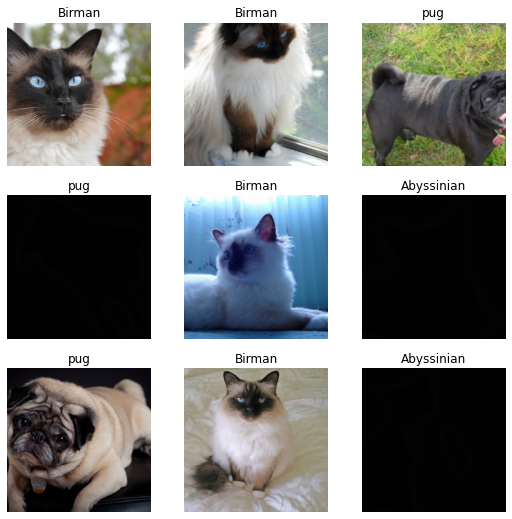

In [ ]:
dls = ImageDataLoaders.from_name_func(
    Path, get_image_files(Path), valid_pct=0.2, seed=420,
    label_func=GetLabel, item_tfms=Resize(224))

dls.train.show_batch()

Making use of ResNet18's pretrained model for Transfer Learning Optimization.

*note cnn_learner has been updated to vision_learner.

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate, pretrained=True)
learn.fine_tune(epochs=20)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.268931,0.494669,0.216667,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.623515,0.371799,0.162500,00:07
1,0.541845,0.355397,0.129167,00:07
2,0.465619,0.358948,0.125000,00:07
3,0.404000,0.328790,0.108333,00:07
4,0.363713,0.390055,0.129167,00:07
5,0.342390,0.403164,0.120833,00:07
6,0.300394,0.339296,0.095833,00:07
7,0.268107,0.411823,0.116667,00:07
8,0.224232,0.434190,0.112500,00:07
9,0.191131,0.448010,0.129167,00:07


## Verify Model

### Upload your own Images

*note - run function and look for a random picture of a pug, abyssinian or birman to upload for trained model to analyse and determine what type of pet it is.

In [ ]:
from google.colab import files
uploader = files.upload()

for img in uploader.items():
  uploadedImg = img[0]

img = PILImage.create(uploadedImg)
img.show()

label,_,probs = learn.predict(img)

print(f"This is a {label}.")
print(f"{labelA} {probs[2].item():.6f}")
print(f"{labelB} {probs[0].item():.6f}")
print(f"{labelC} {probs[1].item():.6f}")

### Test using images in dataset

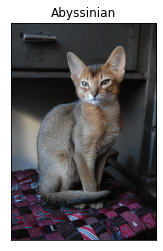

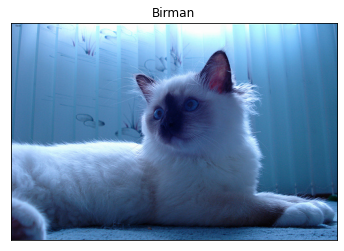

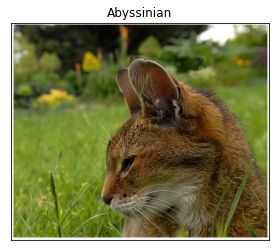

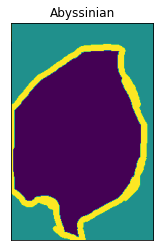

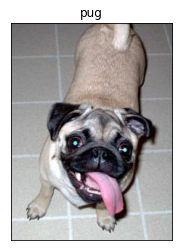

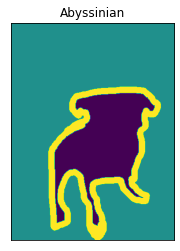

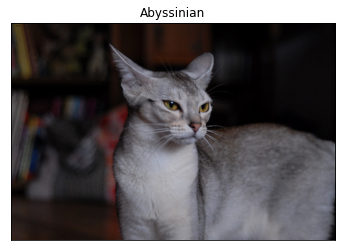

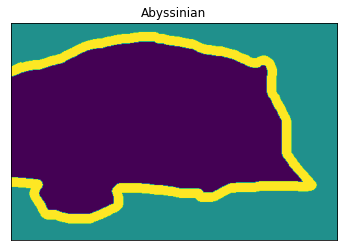

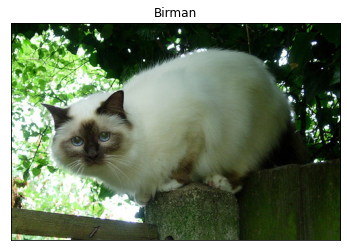

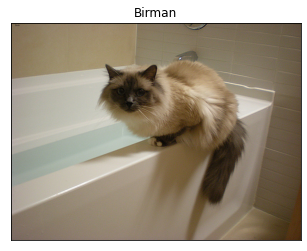

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for i in range(0,10):
  #Load random image
  randomIndex = random.randint(0, len(get_image_files(Path))-1)
  img = mpimg.imread(get_image_files(Path)[randomIndex])
  #Put into Model
  label,_,probs = learn.predict(img)

  #Create Figure using Matplotlib
  fig = plt.figure()
  ax = fig.add_subplot() #Add Subplot (For multiple images)
  imgplot = plt.imshow(img) #Add Image into Plot
  ax.set_title(label) #Set Headline to predicted label

  #Hide numbers on axes
  plt.gca().axes.get_yaxis().set_visible(False)
  plt.gca().axes.get_xaxis().set_visible(False)

### Confusion Matrix (optional)

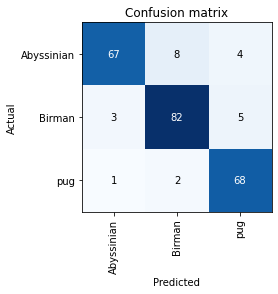

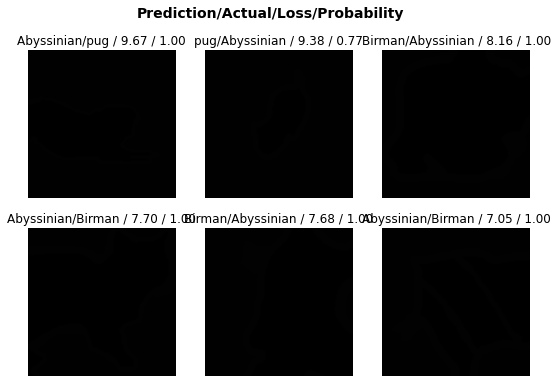

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(6)

## Deploy

In [ ]:
learn.export() #exports model as 'export.pkl' by default

In [ ]:
#grab the pkl file
modelPath = get_files(Path, '.pkl')[0]
modelPath

Path('/root/.fastai/data/oxford-iiit-pet/export.pkl')

In [ ]:
learn_inf = load_learner(modelPath)
learn_inf.predict(mpimg.imread(get_image_files(Path)[0])) #raw prediction

('Abyssinian', TensorBase(0), TensorBase([0.9898, 0.0087, 0.0015]))

In [ ]:
learn_inf.dls.vocab #Get the labels

['Abyssinian', 'Birman', 'pug']

In [ ]:
#This seems to only work properly in Chrome, if using other browsers just remove shield.
from google.colab import files
files.download(modelPath)